### data
    ├── directors.tsv
    ├── genres.tsv
    ├── titles.tsv
    ├── train_ratings.csv
    ├── writers.tsv
    └── years.tsv
    
1. *train_ratings.csv* : 전체 훈련 데이터.
2. *directors.tsv*, *genres.tsv*, *writers.tsv*, *years.tsv*, *titles.tsv* : 영화의 side-information 데이터.

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
data_path = '/opt/ml/input/data/train'

### Main Inforamtion

In [3]:
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터

In [4]:
train_df.info()
train_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5154471 entries, 0 to 5154470
Data columns (total 3 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int64
 1   item    int64
 2   time    int64
dtypes: int64(3)
memory usage: 118.0 MB


,user,item,time
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563


In [5]:
len(train_df)

5154471

data sparsity

In [6]:
num_train_users = train_df['user'].nunique()
num_train_items = train_df['item'].nunique()

print ("Number of unique train users: ", num_train_users)
print ("Number of unique train items: ", num_train_items)

Number of unique train users:  31360
Number of unique train items:  6807


In [7]:
num_train_time = train_df['time'].nunique()
print ("Number of unique train times: ", num_train_time)

Number of unique train times:  5074973


In [8]:
print("Data sparsity ratio: ", 1 - len(train_df) / (num_train_users * num_train_items))

Data sparsity ratio:  0.9758536052697853


user별 item 분포 확인

In [9]:
train_df['user'].nunique()

31360

<AxesSubplot: >

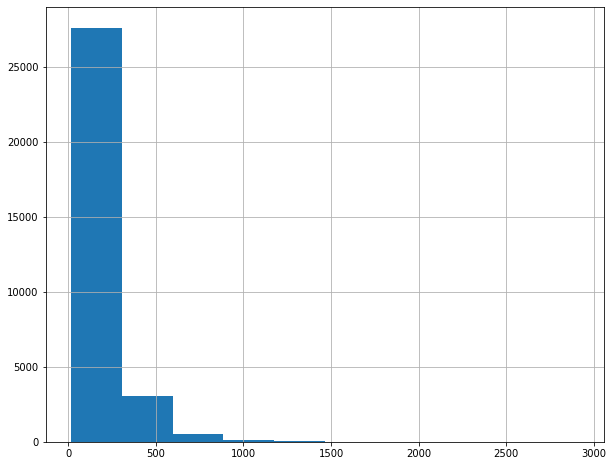

In [10]:
user_grouped = train_df.groupby(train_df['user'])['item'].count()
user_grouped.hist(figsize=(10,8))

<AxesSubplot: >

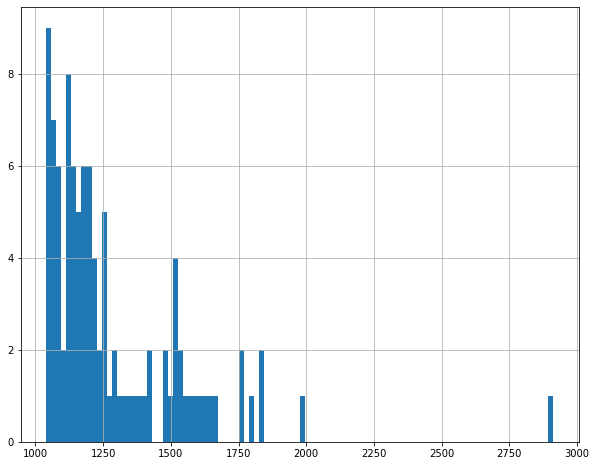

In [11]:
# 상위 100명의 유저들의 영화 시청 개수
train_df['user'].value_counts()[:100].hist(bins=100, figsize=(10,8))

<AxesSubplot: >

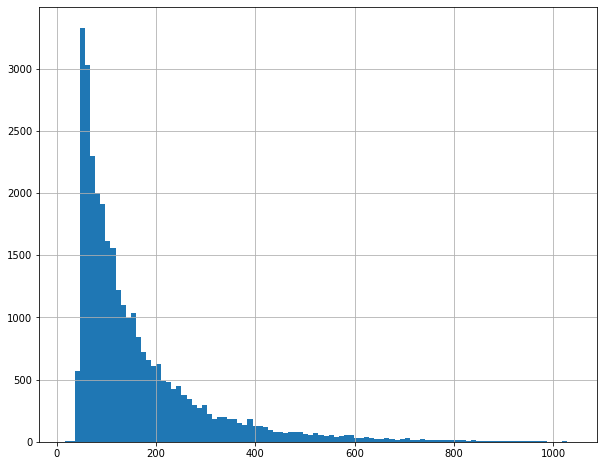

In [12]:
train_df['user'].value_counts()[100:].hist(bins=100, figsize=(10,8))

timestamp

In [13]:
import time

datetime_df = train_df['time'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))
datetime_df.head()

0    2009-01-01 04:02:09
1    2009-01-01 04:02:14
2    2009-01-01 04:02:19
3    2009-01-01 04:02:22
4    2009-01-01 04:02:43
Name: time, dtype: object

In [14]:
datetime_df = datetime_df.str.split(" ", expand=True)
datetime_df.columns = ['date', 'time']
datetime_df

,date,time
0,2009-01-01,04:02:09
1,2009-01-01,04:02:14
2,2009-01-01,04:02:19
3,2009-01-01,04:02:22
4,2009-01-01,04:02:43
...,...,...
5154466,2009-12-07,18:10:49
5154467,2009-12-07,18:11:22
5154468,2009-12-07,18:15:20
5154469,2009-12-07,18:15:26


In [15]:
date_df = datetime_df['date'].str.split("-", expand=True)
date_df.columns = ['year', 'month', 'day'] 
date_df

,year,month,day
0,2009,01,01
1,2009,01,01
2,2009,01,01
3,2009,01,01
4,2009,01,01
...,...,...,...
5154466,2009,12,07
5154467,2009,12,07
5154468,2009,12,07
5154469,2009,12,07


In [16]:
time_df = datetime_df['time'].str.split(":", expand=True)
time_df.columns = ['hour', 'minute', 'second'] 
time_df

,hour,minute,second
0,04,02,09
1,04,02,14
2,04,02,19
3,04,02,22
4,04,02,43
...,...,...,...
5154466,18,10,49
5154467,18,11,22
5154468,18,15,20
5154469,18,15,26


In [17]:
datetime_df = pd.concat([datetime_df, date_df], axis=1)
datetime_df = pd.concat([datetime_df, time_df], axis=1)

In [18]:
list(datetime_df)

['date', 'time', 'year', 'month', 'day', 'hour', 'minute', 'second']

In [19]:
datetime_df.head(10)

,date,time,year,month,day,hour,minute,second
0,2009-01-01,04:02:09,2009,01,01,04,02,09
1,2009-01-01,04:02:14,2009,01,01,04,02,14
2,2009-01-01,04:02:19,2009,01,01,04,02,19
3,2009-01-01,04:02:22,2009,01,01,04,02,22
4,2009-01-01,04:02:43,2009,01,01,04,02,43
5,2009-01-01,04:03:03,2009,01,01,04,03,03
6,2009-01-01,04:04:06,2009,01,01,04,04,06
7,2009-01-01,04:04:16,2009,01,01,04,04,16
8,2009-01-01,04:04:54,2009,01,01,04,04,54
9,2009-01-01,04:05:19,2009,01,01,04,05,19


In [20]:
train_df = pd.concat([train_df, datetime_df], axis=1)
train_df.shape

(5154471, 11)

In [66]:
train_df.columns = ['user', 'item', 'timestamp', 'date', 'time', 'year', 'month', 'day', 'hour', 'minute', 'second']

### Side Information

In [21]:
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

item_df

In [22]:
item_df = pd.merge(year_data, writer_data, on='item', how='outer')
item_df = pd.merge(item_df, title_data, on='item', how='outer')
item_df = pd.merge(item_df, genre_data, on='item', how='outer')
item_df = pd.merge(item_df, director_data, on='item', how='outer')

print(list(item_df))
item_df.head()

['item', 'year', 'writer', 'title', 'genre', 'director']


,item,year,writer,title,genre,director
0,1348,1922.0,nm0831290,"Nosferatu (Nosferatu, eine Symphonie des Graue...",Horror,nm0003638
1,44587,1922.0,NaN,Nanook of the North (1922),Documentary,NaN
2,44587,1922.0,NaN,Nanook of the North (1922),Drama,NaN
3,4768,1922.0,nm0000485,"Dr. Mabuse: The Gambler (Dr. Mabuse, der Spiel...",Crime,nm0000485
4,4768,1922.0,nm0000485,"Dr. Mabuse: The Gambler (Dr. Mabuse, der Spiel...",Mystery,nm0000485


In [23]:
item_df.shape

(37674, 6)

years

In [24]:
year_data.info()
year_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   item    6799 non-null   int64
 1   year    6799 non-null   int64
dtypes: int64(2)
memory usage: 106.4 KB


,item,year
0,1348,1922
1,44587,1922
2,4768,1922
3,8235,1923
4,8609,1923


In [25]:
print ("Year data shape: ", year_data.shape)
print("Number of unique items in year_df: ", year_data['item'].nunique())
print("Number of unique years: ", year_data['year'].nunique())
print ("\nStatistics of year data: ")
year_data['year'].describe()

Year data shape:  (6799, 2)
Number of unique items in year_df:  6799
Number of unique years:  93

Statistics of year data: 


count    6799.000000
mean     1992.174732
std        19.052568
min      1922.000000
25%      1985.000000
50%      1999.000000
75%      2006.000000
max      2014.000000
Name: year, dtype: float64

writers

In [26]:
writer_data.info()
writer_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11306 entries, 0 to 11305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    11306 non-null  int64 
 1   writer  11306 non-null  object
dtypes: int64(1), object(1)
memory usage: 176.8+ KB


,item,writer
2470,103141,nm0047916
10082,2043,nm0914245
3337,8755,nm0147599
8617,3468,nm0744035
1984,106002,nm0004303


In [27]:
writer_data.nunique()

item      5648
writer    2989
dtype: int64

In [28]:
writer_data['writer'].str[:2].nunique()

1

In [29]:
# 작가 별 아이템 통계량
writer_data.groupby('writer')['item'].count().describe()

count    2989.000000
mean        3.782536
std         2.993783
min         2.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        47.000000
Name: item, dtype: float64

titles

- 괄호제거, ', The' 제거 : 6806->6548

In [30]:
title_data.info()
title_data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    6807 non-null   int64 
 1   title   6807 non-null   object
dtypes: int64(1), object(1)
memory usage: 106.5+ KB


,item,title
3189,4976,Iris (2001)
5003,694,"Substitute, The (1996)"
5136,2187,Stage Fright (1950)
673,1569,My Best Friend's Wedding (1997)
898,8781,"Manchurian Candidate, The (2004)"
3071,49932,Inland Empire (2006)
3595,3264,Buffy the Vampire Slayer (1992)
6385,450,With Honors (1994)
4373,40959,"Ice Harvest, The (2005)"
2740,3010,Rosetta (1999)


In [31]:
title_data.nunique()

item     6807
title    6806
dtype: int64

In [32]:
# 괄호와 괄호 내 문자열 제거
title_data['title'] = title_data['title'].str.replace(pat = r'\(.*\)|\s-\s.*', repl=r'', regex=True)
title_data['title'] = title_data['title'].str.replace(pat = r'\, The|\s-\s.*', repl=r'', regex=True)
title_data['title'] = title_data['title'].str.strip()

In [33]:
title_data['title'].nunique()

6548

genres

In [34]:
genre_data.info()
genre_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15933 entries, 0 to 15932
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    15933 non-null  int64 
 1   genre   15933 non-null  object
dtypes: int64(1), object(1)
memory usage: 249.1+ KB


,item,genre
0,318,Crime
1,318,Drama
2,2571,Action
3,2571,Sci-Fi
4,2571,Thriller


In [35]:
genre_data.nunique()

item     6807
genre      18
dtype: int64

In [36]:
grouped_genre = pd.DataFrame(genre_data.groupby('item')['genre'].apply(list))
grouped_genre

,genre
item,
1,"[Adventure, Animation, Children, Comedy, Fantasy]"
2,"[Adventure, Children, Fantasy]"
3,"[Comedy, Romance]"
4,"[Comedy, Drama, Romance]"
5,[Comedy]
...,...
118700,[Drama]
118900,[Drama]
118997,"[Children, Comedy, Fantasy, Musical]"


In [37]:
grouped_genre['count'] = grouped_genre.apply(lambda x: len(x['genre']), axis=1)
grouped_genre['count'].describe()

count    6807.000000
mean        2.340679
std         1.114049
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        10.000000
Name: count, dtype: float64

array([[<AxesSubplot: title={'center': 'count'}>]], dtype=object)

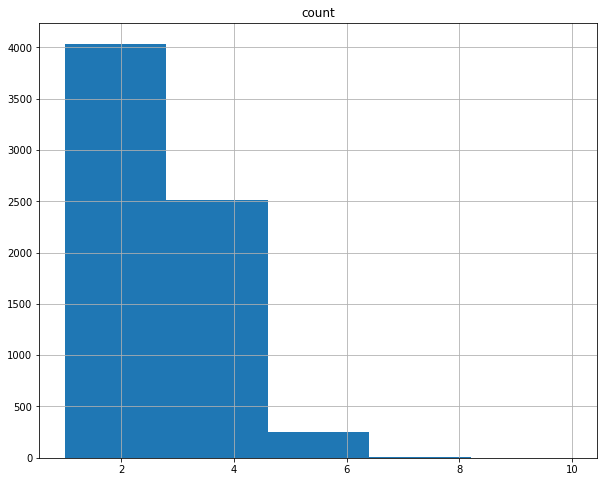

In [38]:
grouped_genre.hist(bins=5, figsize=(10,8))

directors

In [39]:
director_data.info()
director_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5905 entries, 0 to 5904
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   item      5905 non-null   int64 
 1   director  5905 non-null   object
dtypes: int64(1), object(1)
memory usage: 92.4+ KB


,item,director
5813,70159,nm1429471
2338,71254,nm0004410
1777,6263,nm0001532
5140,52245,nm0817447
3280,7208,nm0281808


In [40]:
director_data.nunique()

item        5503
director    1340
dtype: int64

In [41]:
director_data['director'].str[:2].nunique()

1

In [42]:
# 감독 별 아이템 통계량
director_data.groupby('director')['item'].count().describe()

count    1340.000000
mean        4.406716
std         3.633030
min         2.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        44.000000
Name: item, dtype: float64

writer vs director

In [43]:
writer_data['writer'].nunique()

2989

In [44]:
director_data['director'].nunique()

1340

In [45]:
# 교집합 개수
len(set(writer_data['writer']).intersection(set(director_data['director'])))

676

### 데이터 시각화

In [46]:
import matplotlib.pyplot as plt

데이터의 출현 빈도 순 : *active_user_ids*와 *popular_movie_ids*

In [47]:
active_user_ids = train_df.value_counts('user').index[:10]
popular_movie_ids = train_df.value_counts('item').index[:10]

print ("active user ids: ", active_user_ids)
print ("\npopular movie ids: ", popular_movie_ids)

active user ids:  Int64Index([8405, 54465, 24219, 32514, 91349, 131904, 34576, 99754, 31122,
            118754],
           dtype='int64', name='user')

popular movie ids:  Int64Index([2571, 2959, 296, 318, 356, 4993, 7153, 5952, 593, 2858], dtype='int64', name='item')


user-item 빈도수가 높은 데이터 샘플을 미리 저장

In [48]:
director_df = pd.merge(train_df, director_data, on=['item'])
director_id = director_df.value_counts('director').index[:10]

side_df = []
for director in director_id:
    side_df.append(director_df.loc[director_df['director'] == director])

director_top = pd.concat(side_df)

print ("Number of all unique director ids: ", director_df['director'].nunique())
print ("\ntop 10 director ids: \n", director_id)
print ("\nsample of top 10 user-director data: \n", director_top.sample(5))
print ("\nshape of the data: ", director_top.shape)

Number of all unique director ids:  1340

top 10 director ids: 
 Index(['nm0000229', 'nm0000233', 'nm0634240', 'nm0000709', 'nm0001392',
       'nm0000217', 'nm0001054', 'nm0000116', 'nm0000399', 'nm0000631'],
      dtype='object', name='director')

sample of top 10 user-director data: 
            user   item        time        date      time  year month day hour  \
1444264   37619    527  1315854840  2011-09-12  19:14:00  2011    09  12   19   
1498243    9831  48516  1375418682  2013-08-02  04:44:42  2013    08  02   04   
2197546   11849   1089  1205411444  2008-03-13  12:30:44  2008    03  13   12   
941910    35906    296  1237677318  2009-03-21  23:15:18  2009    03  21   23   
921321   113673   2959  1311278792  2011-07-21  20:06:32  2011    07  21   20   

        minute second   director  
1444264     14     00  nm0000229  
1498243     44     42  nm0000217  
2197546     30     44  nm0000233  
941910      15     18  nm0000233  
921321      06     32  nm0000399  

shape of the 

In [49]:
writer_df = pd.merge(train_df, writer_data, on=['item'])
writer_id = writer_df.value_counts('writer').index[:10]

side_df = []
for writer in writer_id:
    side_df.append(writer_df.loc[writer_df['writer'] == writer])

writer_top = pd.concat(side_df)

print ("Number of all unique writer ids: ", writer_df['writer'].nunique())
print ("\ntop 10 writer ids: \n", writer_id)
print ("\nsample of top 10 user-writer data: \n", writer_top.sample(5))
print ("\nshape of the data: ", writer_top.shape)

Number of all unique writer ids:  2989

top 10 writer ids: 
 Index(['nm0000184', 'nm0000233', 'nm0634240', 'nm0001392', 'nm0909638',
       'nm0004056', 'nm0744429', 'nm0101991', 'nm0254645', 'nm0000175'],
      dtype='object', name='writer')

sample of top 10 user-writer data: 
             user  item        time        date      time  year month day hour  \
10310681   74735  1345  1424667735  2015-02-23  05:02:15  2015    02  23   05   
3712949   103642  7153  1282562517  2010-08-23  11:21:57  2010    08  23   11   
1757558    77525  6377  1167383867  2006-12-29  09:17:47  2006    12  29   09   
3692070    60159  7153  1122963229  2005-08-02  06:13:49  2005    08  02   06   
2720709   127900  1291  1201810555  2008-01-31  20:15:55  2008    01  31   20   

         minute second     writer  
10310681     02     15  nm0000175  
3712949      21     57  nm0909638  
1757558      17     47  nm0004056  
3692070      13     49  nm0001392  
2720709      15     55  nm0000184  

shape of the da

In [50]:
title_df = pd.merge(train_df, title_data, on=['item'])
title_id = title_df.value_counts('title').index[:10]


side_df = []
for title in title_id:
    side_df.append(title_df.loc[title_df['title'] == title])

title_top = pd.concat(side_df)

print ("Number of all unique movie titles: ", title_df['title'].nunique())
print ("\ntop 10 movie titles: \n", title_id)
print ("\nsample of top 10 user-title data: \n", title_top.sample(5))
print ("\nshape of the data: ", title_top.shape)

Number of all unique movie titles:  6548

top 10 movie titles: 
 Index(['Matrix', 'Fight Club', 'Pulp Fiction', 'Shawshank Redemption',
       'Forrest Gump', 'Lord of the Rings: The Fellowship of the Ring',
       'Lord of the Rings: The Return of the King',
       'Lord of the Rings: The Two Towers', 'Silence of the Lambs',
       'Gladiator'],
      dtype='object', name='title')

sample of top 10 user-title data: 
           user  item        time        date      time  year month day hour  \
1076407  51986  5952  1338827609  2012-06-04  16:33:29  2012    06  04   16   
807382   47852  2959  1404702718  2014-07-07  03:11:58  2014    07  07   03   
837730   43767   296  1113366961  2005-04-13  04:36:01  2005    04  13   04   
230016   52843  2571  1121071472  2005-07-11  08:44:32  2005    07  11   08   
852108   15120   356  1276060711  2010-06-09  05:18:31  2010    06  09   05   

        minute second                              title  
1076407     33     29  Lord of the Rings: Th

In [52]:
year_data

,item,year
0,1348,1922
1,44587,1922
2,4768,1922
3,8235,1923
4,8609,1923
...,...,...
6794,114795,2014
6795,110771,2014
6796,112804,2014
6797,113378,2014


In [54]:
year_data.columns = ['item', 'item_year']
year_data

,item,item_year
0,1348,1922
1,44587,1922
2,4768,1922
3,8235,1923
4,8609,1923
...,...,...
6794,114795,2014
6795,110771,2014
6796,112804,2014
6797,113378,2014


In [55]:
year_df = pd.merge(train_df, year_data, on=['item'])
year_id = year_df.value_counts('year').index[:10]

side_df = []
for year in year_id:
    side_df.append(year_df.loc[year_df['year'] == year])

year_top = pd.concat(side_df)

print ("All unique years: \n", np.sort(year_df['year'].unique())) 
print ("\nNumber of all unique years: ", year_df['year'].nunique())
print ("\ntop 10 years: \n", year_id)
print ("\nsample of top 10 user-year data: \n", year_top.sample(5))
print ("\nshape of the data: ", year_top.shape)

All unique years: 
 ['2005' '2006' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014'
 '2015']

Number of all unique years:  11

top 10 years: 
 Index(['2008', '2006', '2007', '2005', '2009', '2010', '2011', '2012', '2013',
       '2014'],
      dtype='object', name='year')

sample of top 10 user-year data: 
           user  item        time        date      time  year month day hour  \
1018951  67351  1291  1378562303  2013-09-07  13:58:23  2013    09  07   13   
5138564  48174  1760  1177326989  2007-04-23  11:16:29  2007    04  23   11   
921702   66049   377  1343837672  2012-08-01  16:14:32  2012    08  01   16   
1935502  41282  1089  1236551768  2009-03-08  22:36:08  2009    03  08   22   
4898986  60645  5054  1140208599  2006-02-17  20:36:39  2006    02  17   20   

        minute second  item_year  
1018951     58     23       1989  
5138564     16     29       1997  
921702      14     32       1994  
1935502     36     08       1992  
4898986     36     39       1983  

In [56]:
genre_df = pd.merge(train_df, genre_data, on=['item'])

genre_top = genre_df

print ("All unique genres: \n", np.sort(genre_df['genre'].unique())) 
print ("\nNumber of all unique genres: ", genre_df['genre'].nunique())
print ("\nsample of user-genre data: \n", genre_top.sample(5))
print ("\nshape of the data: ", genre_top.shape)

All unique genres: 
 ['Action' 'Adventure' 'Animation' 'Children' 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']

Number of all unique genres:  18

sample of user-genre data: 
            user  item        time        date      time  year month day hour  \
7868619   35436  1302  1134234546  2005-12-10  17:09:06  2005    12  10   17   
10331312  76057  1672  1262097788  2009-12-29  14:43:08  2009    12  29   14   
2021155   65473  6874  1134407314  2005-12-12  17:08:34  2005    12  12   17   
6566456   93368  5902  1210793005  2008-05-14  19:23:25  2008    05  14   19   
955963    92980  3745  1138479172  2006-01-28  20:12:52  2006    01  28   20   

         minute second    genre  
7868619      09     06    Drama  
10331312     43     08    Drama  
2021155      08     34    Crime  
6566456      23     25  Romance  
955963       12     52   Action  

shape of the data:  (14126324, 12)


<function matplotlib.pyplot.show(close=None, block=None)>

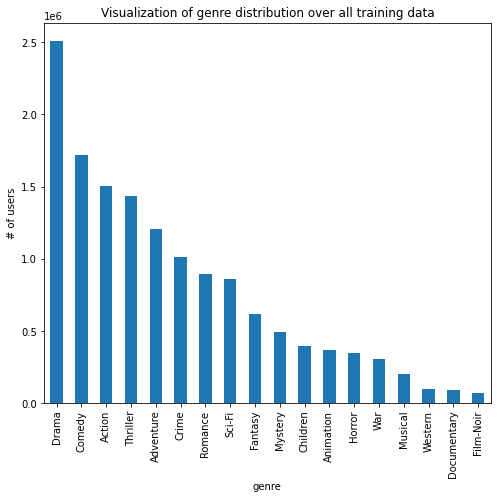

In [57]:
# Drama > ... > Film-Noir
genre_top['genre'].value_counts().plot(kind = 'bar', figsize = (8,7))
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all training data')
plt.show

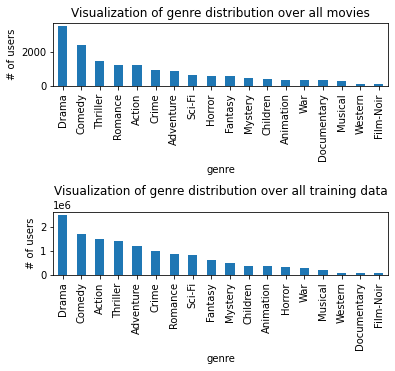

In [58]:
# 전체 훈련데이터 순위 != 영화데이터 순위
plt.subplot(2,1,1)
genre_data['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all movies')

plt.subplot(2,1,2)
genre_top['genre'].value_counts().plot(kind = 'bar')
plt.xlabel('genre')
plt.ylabel('# of users')
plt.title('Visualization of genre distribution over all training data')

plt.subplots_adjust(hspace=2.0, top=1.0)

<AxesSubplot: >

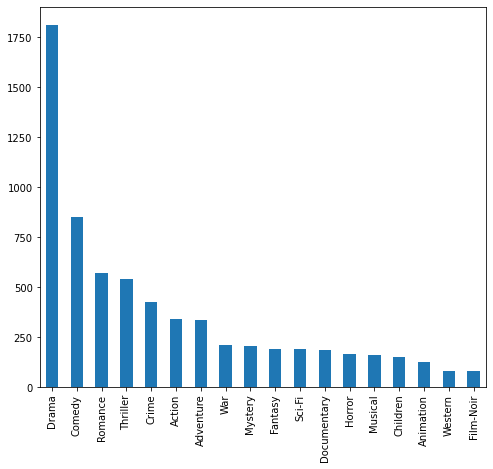

In [59]:
# 특정 유저의 영화 장르 순위
user_id = active_user_ids[0] # specific user id
genre_user = genre_top[genre_top['user'] == user_id]

genre_user['genre'].value_counts().plot(kind = 'bar', figsize = (8,7))

/tmp/ipykernel_85273/2588566963.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  converted_df['timestamp'] = old_df['timestamp'].replace([old_time], new_time) # replace the time column


Text(0.5, 1.0, 'Statistics of user activity')

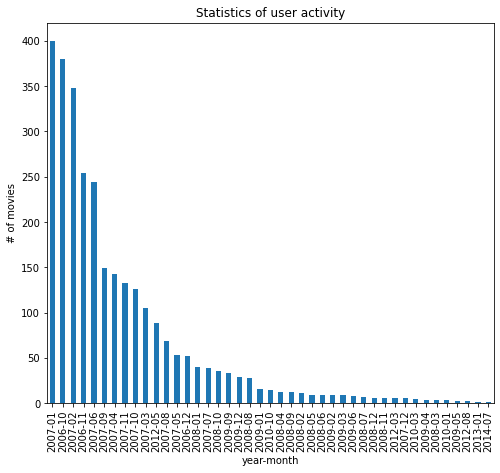

In [65]:
# 특정 유저가 어느 시기에 많은 interaction을 했는가
old_df = train_df[train_df['user'] == active_user_ids[0]] # Specific user id
converted_df = old_df

for old_time in old_df['timestamp']:
    new_time = time.strftime('%Y-%m', time.localtime(old_time))
    converted_df['timestamp'] = old_df['timestamp'].replace([old_time], new_time) # replace the time column

converted_df['timestamp'].value_counts().plot(kind = 'bar', figsize = (8,7))
plt.xlabel('year-month')
plt.ylabel('# of movies')
plt.title('Statistics of user activity')